In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

%matplotlib inline

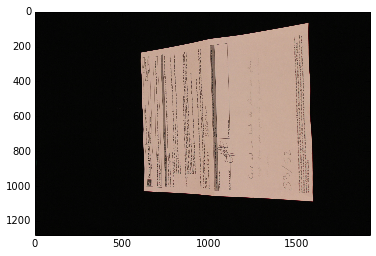

In [6]:
img0 = cv2.imread('./_data/raw/canon 1/IMG_1052.JPG')
#img0 = cv2.imread('./_data/categorized/simple/IMG_1086.JPG')
plt.imshow(img0)

# Image rotation

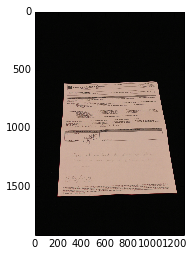

In [8]:
img1 = ndimage.rotate(img0, -90)
plt.imshow(img1)

# Contour detection.

The following is based on these two pages:
 * http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html
 * http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html


In [15]:
imgray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray, 127, 255, 0)

contours, hierarchy = cv2.findContours(thresh,
                                       cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_SIMPLE)

In [16]:
print "Number of contour found: {}\n".format(len(contours))

print "Length of the first contours: ",
for i in range(30):
    print len(contours[i]),
print "...\n"

lengths = [len(cnt) for cnt in contours]
longest = max(lengths)
print "Longest contour: ", longest

ilongest = lengths.index(longest)
print "Index of longest contour: ", ilongest

Number of contour found: 3554

Length of the first contours:  649 6 4 6 4 6 4 4 8 10 10 15 6 11 1 8 4 19 13 13 18 22 15 8 8 4 17 10 8 21 ...

Longest contour:  649
Index of longest contour:  0


Let's approximate the **longest** contour found.

In [17]:
cnt = contours[ilongest]
epsilon = 0.1*cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, epsilon, True)

print "approximative (first) contour:\n{}".format(approx)

approximative (first) contour:
[[[1041  608]]

 [[ 251  621]]

 [[ 193 1587]]

 [[1210 1561]]]


 * For ./_data/categorized/simple/IMG_1086.JPG, it is the longest (and fourth one) that is the right one...
 * For ./_data/canon/IMG_1052.JPG, it is the longest one (and the first one).

It seems that the longest contour is always the one surrounding the page!


Let's match the point of the contour.
First one is the top left corners, then trigo order.

In [18]:
v = [i[0][0]+i[0][1] for i in approx]
topleft = v.index(min(v))
print "point at top left is number {}".format(topleft)

v = [i[0][0]-i[0][1] for i in approx]
bottomleft = v.index(min(v))
print "point at bottom left is number {}".format(bottomleft)

v = [i[0][0]+i[0][1] for i in approx]
bottomright = v.index(max(v))
print "point at bottom right is number {}".format(bottomright)

v = [i[0][0]-i[0][1] for i in approx]
topright = v.index(max(v))
print "point at top right is number {}".format(topright)

ordered_indexes = [topleft, bottomleft, bottomright, topright]
print ordered_indexes

ordered_contour = [approx[i] for i in ordered_indexes]
print ordered_contour

point at top left is number 1
point at bottom left is number 2
point at bottom right is number 3
point at top right is number 0
[1, 2, 3, 0]
[array([[251, 621]], dtype=int32), array([[ 193, 1587]], dtype=int32), array([[1210, 1561]], dtype=int32), array([[1041,  608]], dtype=int32)]


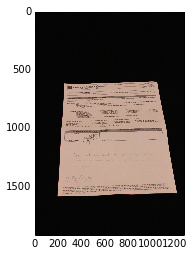

In [19]:
cv2.drawContours(img1, ordered_contour, -1, (0,255,0), 3)
cv2.imwrite("out1.jpg", img1)
plt.imshow(img1)

Let's make it a function.

In [37]:
def findPageContour(img):
    """Return the contour of the scanned page within the image.
    The first point is the one at top left. Order is counter clockwise."""
    # Find all the contours in the image
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh,
                                           cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE)
    # The longest contour is the one surrounding the page
    lengths = [len(cnt) for cnt in contours]
    longest = max(lengths)
    indexLongest = lengths.index(longest)
    cnt = contours[indexLongest]
    # Let's approximate the longest contour to have only four points
    epsilon = 0.1*cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    # Let's sort the points to have them starting from topleft, counter-clockwise
    v = [i[0][0]+i[0][1] for i in approx]
    topleft = v.index(min(v))
    v = [i[0][0]-i[0][1] for i in approx]
    bottomleft = v.index(min(v))
    v = [i[0][0]+i[0][1] for i in approx]
    bottomright = v.index(max(v))
    v = [i[0][0]-i[0][1] for i in approx]
    topright = v.index(max(v))
    ordered_indexes = [topleft, bottomleft, bottomright, topright]
    ordered_contour = [approx[i] for i in ordered_indexes]
    return ordered_contour

# Determine 'A4' zone

In [43]:
def computeA4subarea(img):
    """Return the dimension (rows, cols) of the biggest subarea
    of the image that would have the same proportion than an
    A4 page."""
    rows, cols, ch = img.shape
    rowsA4, colsA4 = 297, 210
    newrows, newcols = rows, cols
    if 1.0*rows/cols > rowsA4/colsA4:
        newrows = int(1.0 * cols * rowsA4 / colsA4)
    else:
        newcols = int(1.0 * rows * colsA4 / rowsA4)
    return newrows, newcols

rows, cols, ch = img1.shape
print "image dimension:    ", rows, cols
newrows, newcols = computeA4subarea(img1)
print "proposed dimension: ", newrows, newcols


image dimension:     1920 1280
proposed dimension:  1810 1280


# Changement of perspective

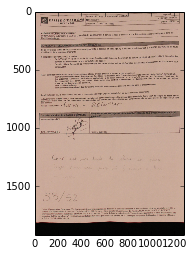

In [10]:
# The points that will define the transformation
pts_origin = np.float32(ordered_contour)
pts_destination = np.float32([[0,0],
                              [0,newrows],
                              [newcols,newrows],
                              [newcols,0]
                              ])

# Apply the transformation
M = cv2.getPerspectiveTransform(pts_origin, pts_destination)
img2 = cv2.warpPerspective(img1, M, (cols,rows))

cv2.imwrite("out2.jpg", img2)

plt.imshow(img2)

# Crop the image

1810 1280
(1920, 1280, 3)
(1810, 1280, 3)


True

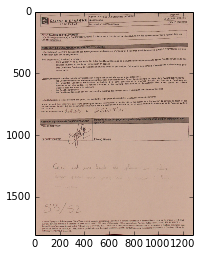

In [11]:
print newrows, newcols
print img2.shape

img3 = img2[0:newrows, 0:newcols]

print img3.shape
plt.imshow(img3)

cv2.imwrite("out3.jpg", img3)


# Detect a black picture

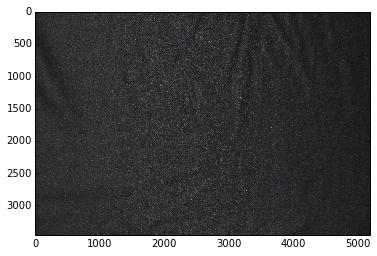

In [12]:
imgblack0 = cv2.imread('./_data/categorized/black/IMG_1141.JPG')
plt.imshow(imgblack0)

In [13]:
rows, cols, ch = imgblack0.shape

print rows, cols
for y in range(rows/4, rows, rows/4):
    for x in range(cols/4, cols, cols/4):
        print x, y, imgblack0[y, x]


3456 5184
1296 864 [49 48 50]
2592 864 [54 54 54]
3888 864 [39 38 42]
1296 1728 [47 40 47]
2592 1728 [44 39 48]
3888 1728 [54 54 54]
1296 2592 [50 49 51]
2592 2592 [48 47 51]
3888 2592 [45 50 41]


320 452 [165 140 124]
640 452 [200 168 149]
960 452 [198 165 150]
320 904 [136 112  95]
640 904 [131 108  93]
960 904 [129 106  94]
320 1356 [201 169 154]
640 1356 [200 170 153]
960 1356 [192 159 143]
320 1808 [199 169 152]
640 1808 [14  6  7]
960 1808 [101  39  31]


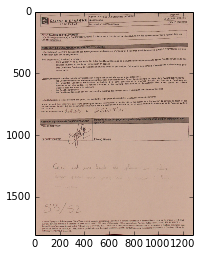

In [14]:
plt.imshow(img3)

rows, cols, ch = img3.shape

for y in range(rows/4, rows, rows/4):
    for x in range(cols/4, cols, cols/4):
        print x, y, img3[y, x]
        


In [27]:
def isBlack(img):
    rows, cols, ch = img.shape
    sumb = sumt = 0
    div = 10
    for y in range(rows/div, rows, rows/div):
        for x in range(cols/div, cols, cols/div):
            rgb = img[y, x]
            if rgb[0] < 100 and rgb[1] < 100 and rgb [2] < 100:
                sumb += 1
            sumt += 1
    return 1.0 * sumb / sumt > 0.9

print "mainly white:", isBlack(img3)
print "white in the middle:", isBlack(img0)
print "mainly black:", isBlack(imgblack0)
            

mainly white: False
white in the middle: False
mainly black: True


In [44]:
import os


paths = ['./_data/categorized/black',
         './_data/categorized/simple']

for path in paths:
    print "\n", path, ": "
    for imgfile in os.listdir(path):
        im = cv2.imread(os.path.join(path, imgfile))
        print isBlack(im),
    



./_data/categorized/black : 
True True True True True True 
./_data/categorized/simple : 
False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False


In [93]:
#bytes = img2pdf("./_data/canon/IMG_1052.JPG", dpi=150)

import img2pdf

path = './_data/categorized/simple'
images = os.listdir(path)
images = [os.path.join(path, i) for i in images]
print images
pdf_bytes = img2pdf.convert(images, dpi=25)

file = open("name.pdf","wb")
file.write(pdf_bytes)
close(file)

#print help(img2pdf.convert)

['./_data/categorized/simple/IMG_1086.JPG', './_data/categorized/simple/IMG_1087.JPG', './_data/categorized/simple/IMG_1088.JPG', './_data/categorized/simple/IMG_1089.JPG', './_data/categorized/simple/IMG_1090.JPG', './_data/categorized/simple/IMG_1091.JPG', './_data/categorized/simple/IMG_1092.JPG', './_data/categorized/simple/IMG_1093.JPG', './_data/categorized/simple/IMG_1094.JPG', './_data/categorized/simple/IMG_1095.JPG', './_data/categorized/simple/IMG_1096.JPG', './_data/categorized/simple/IMG_1097.JPG', './_data/categorized/simple/IMG_1098.JPG', './_data/categorized/simple/IMG_1099.JPG', './_data/categorized/simple/IMG_1100.JPG', './_data/categorized/simple/IMG_1102.JPG', './_data/categorized/simple/IMG_1103.JPG', './_data/categorized/simple/IMG_1104.JPG', './_data/categorized/simple/IMG_1105.JPG', './_data/categorized/simple/IMG_1106.JPG', './_data/categorized/simple/IMG_1107.JPG', './_data/categorized/simple/IMG_1108.JPG', './_data/categorized/simple/IMG_1110.JPG', './_data/c

NameError: name 'close' is not defined

In [99]:
"----{:0>30}----".format(23)

'----000000000000000000000000000023----'

In [100]:
os.mkdir('ttempo')

In [111]:
os.listdir("_data/categorized/simple")
os.path.basename("_data/categorized/simple/IMG_1086.JPG")

'IMG_1086.JPG'